In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from src.leachSFtree import leachSFClusteringJoin, leachSFClusteringTreeJoin
from src.mst_prim import prim_mst, create_routes_dict
import src.util as util
import src.topology as topology
import networkx as nx
from src.nova_join import Operator, OperatorType, NovaSolver
from src.util import log_opt_label, coordinator_label, worker_label, centroid_label, ch_label, join_label
from src.cardinalities import create_cardinalities, create_adjacency_matrix, create_unique_n_tuples, \
    create_adjacency_matrix_from_pairs, generate_random_integer_dict
from src.util import evaluate_graph, evaluate_routes, plot_distributions_pdf
from src.topology import transition_uniform_to_exponential, create_topologies_from_dict
from src.baselines import sink_based_placement, source_based_placement, top_c
from src.eval_tools import *

### Topology Setup

In [2]:
seed = 10

worker_capacity = (1, 200)
source_capacity = (1, 50)
source_frac = 0.6
coord_cols = ["x", "y"]

X_dim = [-40, 75]
Y_dim = [-150, 150]
centers = 10
clustering = False

eval_matrix = {}

In [3]:
t_label = "planetlab"
coord_dict = {t_label: topology.coords_PLANETLAB()}
device_number = coord_dict[t_label].shape[0]

In [4]:
prim_df, base_col, capacity_columns = \
create_topologies_from_dict(coord_dict, coord_cols, worker_capacity=worker_capacity,
                            source_capacity=source_capacity, source_frac=source_frac, with_clustering=clustering,
                            seed=seed)[t_label]

eval_columns = [base_col] + capacity_columns
opt_k = prim_df["cluster"].nunique()
num_sources = prim_df[prim_df["type"] == "SOURCE"].shape[0]
num_workers = prim_df[prim_df["type"] == "WORKER"].shape[0]
num_sinks = prim_df[prim_df["type"] == "SINK"].shape[0]
sink_indices = prim_df[prim_df["type"] == "SINK"].index.tolist()
coord_dict = prim_df[coord_cols].apply(list, axis=1).to_dict()

print(f"n={prim_df.shape[0]}, sinks={num_sinks}, workers={num_workers}, sources={num_sources}")
prim_df.head(10)

Creating df for planetlab
Done
n=469, sinks=1, workers=188, sources=280


,x,y,label,cluster,latency,type,capacity_inf,capacity_0,capacity_1,capacity_2,capacity_3,capacity_4,capacity_5
0,34.4285,-119.7220,US West,0,0.000000,SINK,9999999,100,100,100,100,100,100
1,40.7292,-73.9934,US West,0,46.160629,SOURCE,9999999,38,32,28,25,22,20
2,40.7292,-73.9934,US West,0,46.160629,SOURCE,9999999,2,5,6,8,9,10
3,37.4294,-122.1720,US West,0,3.874003,SOURCE,9999999,32,41,46,51,55,58
4,29.7225,-95.3924,US West,0,24.780554,SOURCE,9999999,37,49,56,62,67,72
5,35.9483,-83.9367,US West,0,35.817558,SOURCE,9999999,25,21,18,16,14,12
6,35.9483,-83.9367,US West,0,35.817558,SOURCE,9999999,12,12,12,12,13,13
7,55.7024,12.5622,Europe,0,133.983911,SOURCE,9999999,10,27,36,44,51,58
8,49.2637,-123.2370,US West,0,15.245930,SOURCE,9999999,38,25,18,12,6,1
9,49.2637,-123.2370,US West,0,15.245930,SOURCE,9999999,9,10,11,12,12,13


Total: Step 0 -> Sum: 24822, Mean: 53.04, Median: 34.50, Min: 1.00, Max: 197.00
Total: Step 1 -> Sum: 24818, Mean: 53.03, Median: 34.00, Min: 2.00, Max: 307.00
Total: Step 2 -> Sum: 24809, Mean: 53.01, Median: 35.00, Min: 1.00, Max: 373.00
Total: Step 3 -> Sum: 24816, Mean: 53.03, Median: 35.00, Min: 1.00, Max: 428.00
Total: Step 4 -> Sum: 24827, Mean: 53.05, Median: 32.00, Min: 0.00, Max: 477.00
Total: Step 5 -> Sum: 24807, Mean: 53.01, Median: 28.00, Min: 0.00, Max: 523.00
SOURCE: Step 0 -> Sum: 6803, Mean: 24.30, Median: 25.00, Min: 1.00, Max: 49.00
SOURCE: Step 1 -> Sum: 6799, Mean: 24.28, Median: 25.00, Min: 2.00, Max: 76.00
SOURCE: Step 2 -> Sum: 6787, Mean: 24.24, Median: 22.00, Min: 1.00, Max: 94.00
SOURCE: Step 3 -> Sum: 6801, Mean: 24.29, Median: 19.50, Min: 1.00, Max: 110.00
SOURCE: Step 4 -> Sum: 6804, Mean: 24.30, Median: 19.00, Min: 0.00, Max: 124.00
SOURCE: Step 5 -> Sum: 6791, Mean: 24.25, Median: 18.00, Min: 0.00, Max: 137.00
Total Mean: 53


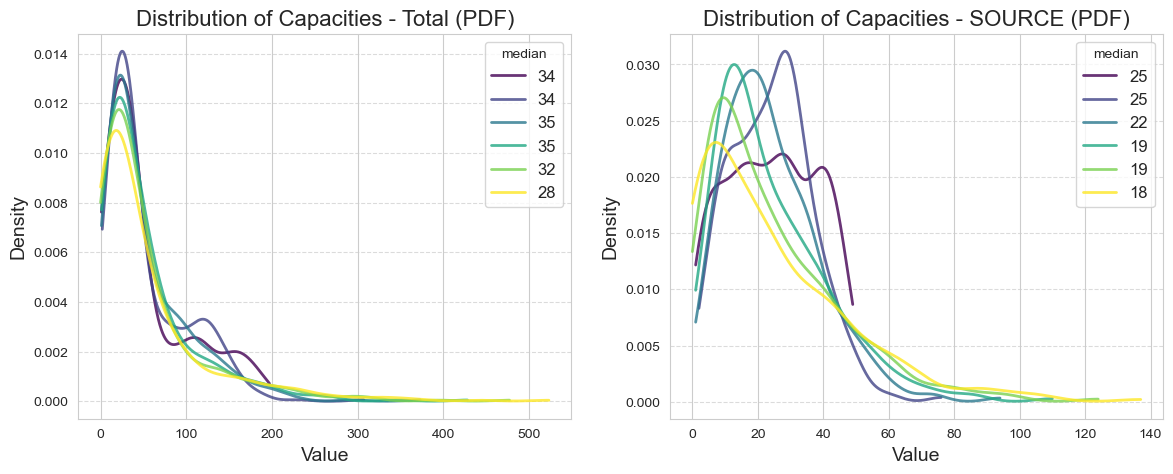

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Display the total distributions
distributions = []
medians = []
total_mean = []
sum_capacities = 0
for i, col in enumerate(capacity_columns):
    dist = prim_df[prim_df["type"] != "SINK"][col].to_numpy()
    distributions.append(dist)
    medians.append(np.median(dist))
    total_mean.append(np.mean(dist))
    sum_capacities += np.sum(dist)
    print(f"Total: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
sum_capacities = sum_capacities // len(distributions)
# Plot the PDFs
dist_colors = plt.cm.viridis(np.linspace(0, 1, len(distributions)))
plot_distributions_pdf(axes[0], distributions, dist_colors)
axes[0].set_title('Distribution of Capacities - Total (PDF)', fontsize=16)

# Display the individual distributions
for cnt_idx, type in enumerate(["SOURCE"]):
    dist_type = []
    for i, col in enumerate(capacity_columns):
        dist = prim_df[prim_df["type"] == type][col].to_numpy()
        dist_type.append(dist)
        print(f"{type}: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
    # Plot the PDFs
    dist_colors = plt.cm.viridis(np.linspace(0, 1, len(dist_type)))
    plot_distributions_pdf(axes[cnt_idx+1], dist_type, dist_colors)
    axes[cnt_idx+1].set_title(f'Distribution of Capacities - {type} (PDF)', fontsize=16)

total_mean = int(np.mean(total_mean))
print("Total Mean:", total_mean)

plt.savefig("plots/planetlab/planetlab_{0}_capacity_dist.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [6]:
colors, colors_hex, light_colors = util.get_color_list(opt_k)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

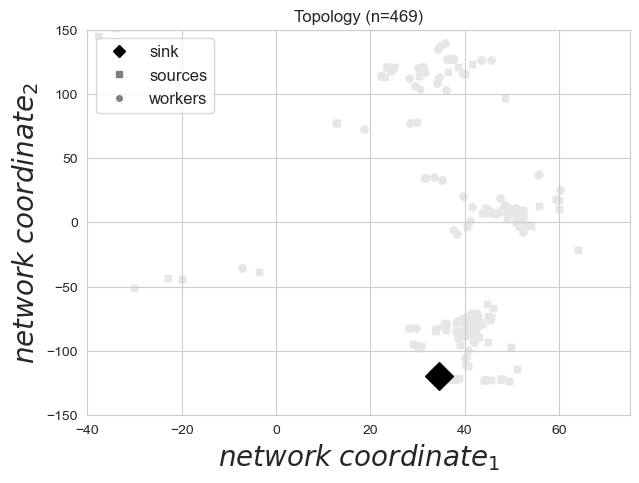

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=True, show_coordinator=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/planetlab/planetlab_{0}_ncs.svg".format(str(device_number)), bbox_inches="tight")

plt.title(f"Topology (n={device_number})")

plt.show()

### Create Join Matrix

In [8]:
# Create a list of labels for the index and columns
source_indices = list(prim_df[prim_df["type"] == "SOURCE"].index.values)
sink_capacity = len(source_indices) * 5
input_range = [1, 75]
output_range = [1, 200]
total_sum_sources = (np.mean(input_range) * num_sources)
prim_df.loc[prim_df[prim_df["type"] == "SINK"].index, capacity_columns] = sink_capacity + 0.2*sink_capacity
print(
    f"Sources={len(source_indices)}, Sum capacities={sum_capacities}; Sum load sources={total_sum_sources}; Sum load output={sink_capacity}")

source_cardinalities = generate_random_integer_dict(source_indices, total_sum_sources, input_range[0], input_range[1],
                                                    seed=seed)
join_pairs, unassigned = create_unique_n_tuples(source_indices, 2, shuffle=False)
join_matrix_df, join_matrix, required = create_adjacency_matrix_from_pairs(prim_df.shape[0], join_pairs, output_range,
                                                           output_sum=sink_capacity, seed=seed)
print(f"Required resources for sinks:{required}")
join_matrix_df.head(10)

Sources=280, Sum capacities=24816; Sum load sources=10640.0; Sum load output=1400
Generating n=280 random integers between 1 and 75, sum=10640.0
Generating n=140 random integers between 1 and 200, sum=1400
Required resources for sinks:1400


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

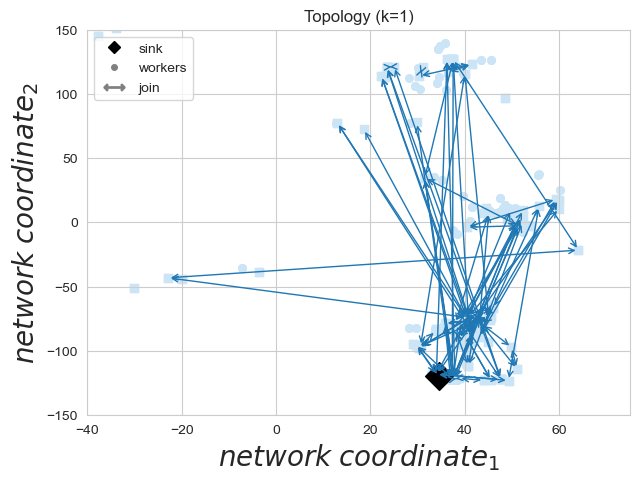

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

for i, j in join_pairs:
    if join_matrix[i, j] > 0:
        point1 = prim_df.iloc[i][coord_cols].to_numpy()
        point2 = prim_df.iloc[j][coord_cols].to_numpy()
        cluster = prim_df.loc[i, "cluster"]
        # print(i, j, point1, point2)
        arrow = FancyArrowPatch(point1, point2, arrowstyle='<->', mutation_scale=10, color=colors[cluster], linewidth=1)
        ax1.add_patch(arrow)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, worker_label, join_label]
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(0, 1), prop={'size': 10})

plt.savefig(f"plots/planetlab/planetlab_{device_number}_ncs_grouped_{source_frac}.svg", bbox_inches="tight")

plt.show()

### Create Logical Plan

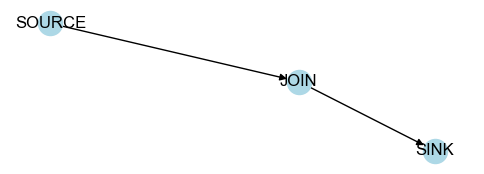

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=OperatorType.SOURCE)
logical_plan.add_node(2, type=OperatorType.JOIN)
logical_plan.add_node(3, type=OperatorType.SINK)

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 2, 1), (2, 3, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog='neato')
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='lightblue')

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

# Show the plot
plt.show()

## Perform Placement

### Nova

In [11]:
reduction_fac=0.4
cardinality_dict = {1: source_cardinalities, 2: (join_matrix, join_pairs)}

df_stats = None
nova_placements = {}

In [12]:
for capacity_col in eval_columns: #[eval_columns[2]]:
    print("Starting nova placement for", capacity_col)
    pdf = prim_df.copy()

    if capacity_col == base_col:
        nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      knn_neighbors=2, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False, pre_knn=False)
    else:
        nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      knn_radius=150, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False, pre_knn=False)

    df_nova_it, rep_plan_it, rel_positions_it, placement_it = nova.nova_full()

    nova_placements[capacity_col] = df_nova_it, rep_plan_it, rel_positions_it, placement_it
    df_stats_it = evaluate_graph(df_nova_it, rep_plan_it)
    eval_matrix["nova_" + capacity_col] = df_stats_it.copy()

Starting nova placement for capacity_inf
Initializing Nova for 469
Running Nova on capacity_inf
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=421 nodes
Relaxed positions: 421
Replicas for 1:280
Replication count for upstream operators to 1 -> 0
Replicas for 2:140
Distributing load: operator_id=470, opt=[38.58368035467072, -89.56536401442924], upstream_nodes=([np.int64(1), np.int64(2)])
Left=12, right=18, batches=6, batch_factor=0.4, batch_threshold=6.0, required=72, part_req=12 resource_limit=4999999.0, neighbor_size=2
Searching knn [38.58368035467072, -89.56536401442924] 468 2 2 0
Distributing finished: operator_id=470 (1, 2) to n=1, opt=[38.58368035467072, -89.56536401442924], upstream_nodes=[78], additional load=0.0
Distributing load: operator_id=471, opt=[33.798025629673674, -112.10537634875287], upstream_nodes=([np.int64(3), np.int64(4)])
Left=66, right=34, batches=8, batch_factor=0.4, batch

In [13]:
for k, vals in nova_placements.items():
    df_nova, rep_plan_nova, rel_positions_nova, placement_nova = vals
    if df_nova[df_nova["free_capacity"] < 0].shape[0] > 0:
        print(f"Overloaded: {k}->{df_nova[df_nova['free_capacity'] < 0].shape[0]}")

In [14]:
plot_col = eval_columns[2]
df_nova, rep_plan_nova, rel_positions_nova, placement_nova = nova_placements[plot_col]

In [15]:
df_nova.head(10)

,x,y,type,unbalanced,weight,real_weight,total_capacity,free_capacity,level,parent
0,34.4285,-119.7220,SINK,0,0,0,1680,276.24,2,[]
1,40.7292,-73.9934,SOURCE,0,12,12,32,32.00,0,"[(420, 12)]"
2,40.7292,-73.9934,SOURCE,0,18,18,5,5.00,0,"[(420, 18)]"
3,37.4294,-122.1720,SOURCE,0,66,66,41,41.00,0,"[(420, 66)]"
4,29.7225,-95.3924,SOURCE,0,34,34,49,49.00,0,"[(420, 34)]"
5,35.9483,-83.9367,SOURCE,0,31,31,21,21.00,0,"[(341, 31)]"
6,35.9483,-83.9367,SOURCE,0,11,11,12,12.00,0,"[(341, 11)]"
7,55.7024,12.5622,SOURCE,0,75,75,27,27.00,0,"[(363, 75)]"
8,49.2637,-123.2370,SOURCE,0,3,3,25,25.00,0,"[(363, 3)]"
9,49.2637,-123.2370,SOURCE,0,45,45,10,10.00,0,"[(341, 45)]"


In [16]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5'])

#### Replication Plan

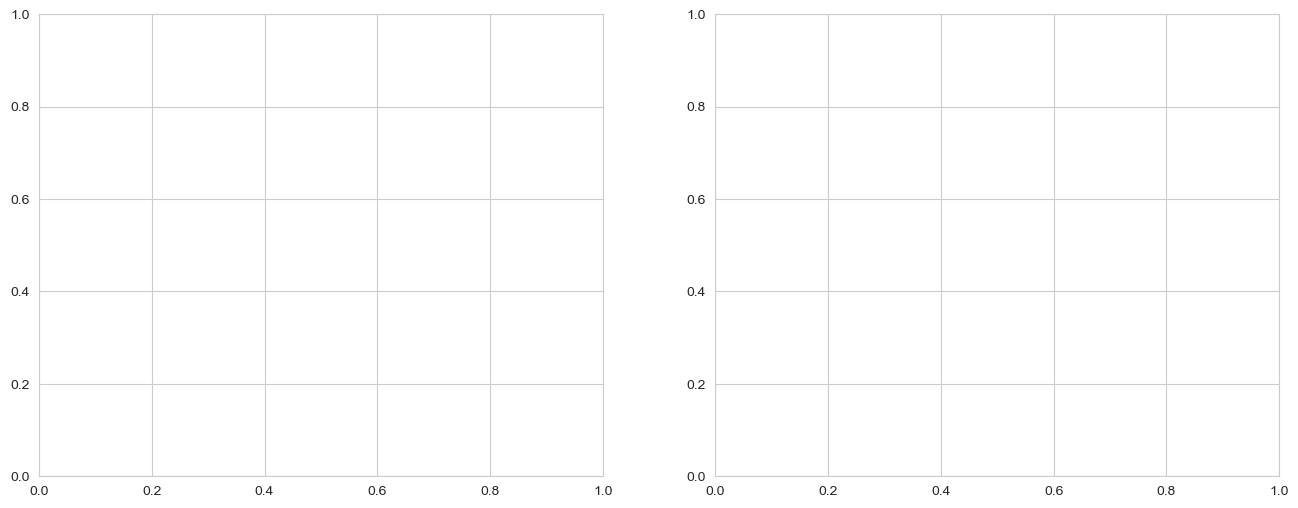

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i_ax, edge_type in enumerate(["distance", "cardinality"]):
    if num_sources > 100:
        break
    # Draw the graph
    pos = nx.nx_agraph.graphviz_layout(rep_plan_nova, prog='neato')
    nx.draw(rep_plan_nova, pos, ax=axs[i_ax], with_labels=False, arrows=True, node_color='lightblue')

    # Extract and draw node labels
    node_labels = nx.get_node_attributes(rep_plan_nova, 'type')
    nx.draw_networkx_labels(rep_plan_nova, pos, ax=axs[i_ax], labels=node_labels)

    # Extract and draw edge labels based on edge attributes
    edge_labels = nx.get_edge_attributes(rep_plan_nova, edge_type)  # Replace 'attribute_name' with your edge attribute key
    nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs[i_ax], edge_labels=edge_labels)
    axs[i_ax].set_title("Replication Plan: " + edge_type)

# Show the plot
plt.show()

#### Placement

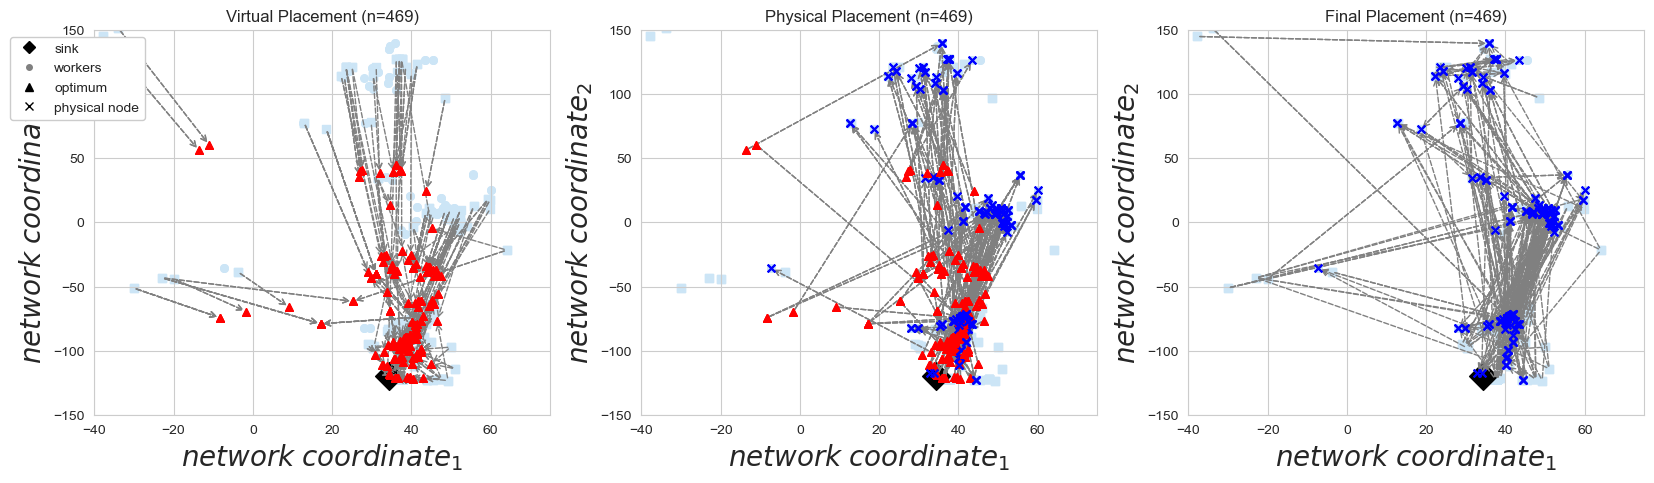

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax1, ax2, ax3 = axs
df_nova["cluster"] = 0

# resolve the placement
placement_coords = dict()
for key, val in placement_nova.items():
    placement_coords[key] = df_nova.loc[val, coord_cols].to_numpy()

ax1 = util.plot_topology(ax1, df_nova, colors=colors, title='Virtual Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax2 = util.plot_topology(ax2, df_nova, colors=colors, title='Physical Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax3 = util.plot_topology(ax3, df_nova, colors=colors, title='Final Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)

for n1, n2 in rep_plan_nova.edges:
    if n2 not in df_nova.index:
        # plot the logical nodes
        ax1.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)
        ax2.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)

        # plot the physical nodes
        ax2.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)
        ax3.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)

    if n2 in df_nova.index:
        # arrow to the sink
        #arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="-", mutation_scale=10, color="grey", linewidth=1)
        #ax3.add_patch(arrow)
        continue
    else:
        color = "grey"
        # physical nodes -> virtual nodes
        arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax1.add_patch(arrow)
        #arrow = FancyArrowPatch(rel_positions[n1], rel_positions[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color=color, linewidth=1)
        #ax2.add_patch(arrow)
        # virtual node -> physical node
        arrow = FancyArrowPatch(rel_positions_nova[n2], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax2.add_patch(arrow)
        arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax3.add_patch(arrow)

    #arrow = FancyArrowPatch(placement[n1], placement[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color="grey", linewidth=1)
    #ax3.add_patch(arrow)

handles = [coordinator_label, worker_label, log_opt_label, ch_label]
ax3.get_legend().remove()
ax2.get_legend().remove()
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(-0.2, 1), prop={'size': 10}, framealpha=1)

for ax in axs:
    ax.set_xlim(X_dim)
    ax.set_ylim(Y_dim)

plt.savefig(f"plots/planetlab/planetlab_{device_number}_nova_complete_{source_frac}.svg", bbox_inches="tight")
plt.show()

## Baselines

### Experiment 1: Sink-based - Placement at the Sink


In [19]:
df_stats = sink_based_placement(coord_dict, sink_indices, join_pairs, source_cardinalities)
eval_matrix["sink-based"] = df_stats.copy()
df_stats.head()

,latency_distribution,received_packets
0,0.0,10640.0
1,46.0,0.0
2,46.0,0.0
3,3.0,0.0
4,24.0,0.0


### Experiment 2: Source-based - Placement at the Sources

In [20]:
df_stats = source_based_placement(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities)
eval_matrix["source-based"] = df_stats.copy()

In [21]:
df_stats.head()

,latency_distribution,received_packets
0,0.0,1400.0
1,46.0,0.0
2,46.0,12.0
3,3.0,34.0
4,30.0,0.0


### Experiment 3: Top-C - Placement at Highest Capacity Nodes

In [22]:
for capacity_col in eval_columns:
    df_stats = top_c(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities, capacity_col)
    eval_matrix["top-c_" + capacity_col] = df_stats.copy()
df_stats.head()

,latency_distribution,received_packets
0,0.0,1400.0
1,208.0,0.0
2,208.0,0.0
3,256.0,0.0
4,230.0,0.0


### Experiment 3: Tree - Placement at intersections 

In [23]:
mst_coords = prim_df[coord_cols].apply(lambda row: tuple(row), axis=1).to_dict()
mst = prim_mst(mst_coords, root=0)
routes = create_routes_dict(mst)

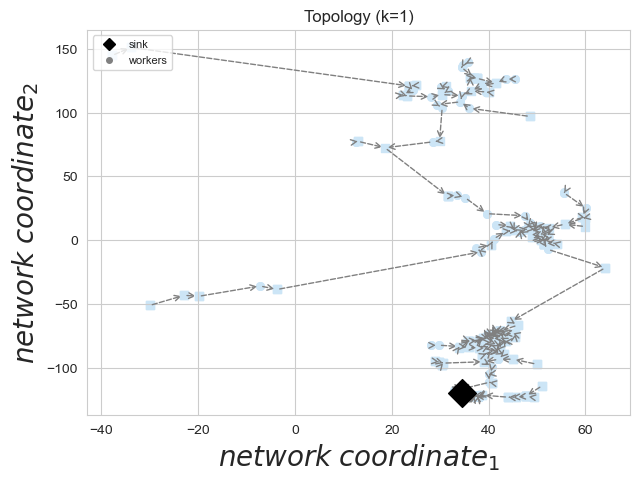

In [24]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
edge_color = "grey"

for node, parent in mst.items():
    point1 = prim_df.loc[node, coord_cols].to_numpy()
    point2 = prim_df.loc[parent, coord_cols].to_numpy()
    arrow = FancyArrowPatch(point1, point2, arrowstyle='->', linestyle="--", mutation_scale=10, color=edge_color,
                            linewidth=1)
    ax1.add_patch(arrow)

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/planetlab/planetlab_{0}_mst.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [25]:
df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
eval_matrix["tree"] = df_stats.copy()
df_stats.head()

,latency_distribution,received_packets
0,0.000000,4308.0
1,53.360455,2763.0
2,53.360455,0.0
3,4.089234,19.0
4,37.683986,131.0


### Clustering - Placement at intersecting Centroids

In [26]:
num_leach_clusters = max(4, int(0.1 * device_number))

df_cl_join = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_cl_join, ch_indices, centers, u = leachSFClusteringJoin(df, capacity_col, num_leach_clusters)
    # evaluation
    routes = df_cl_join["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
    eval_matrix["cl-sf_" + capacity_col] = df_stats.copy()

In [27]:
df_cl_join.head()

,oindex,x,y,type,cluster,capacity_5,parent,route,level
0,0,34.4285,-119.7220,SINK,-1,1680,NaN,[],2
1,1,40.7292,-73.9934,SOURCE,27,20,75.0,"[75, 0]",0
2,2,40.7292,-73.9934,SOURCE,27,10,75.0,"[75, 0]",0
3,3,37.4294,-122.1720,SOURCE,32,58,213.0,"[213, 0]",0
4,4,29.7225,-95.3924,SOURCE,13,72,108.0,"[108, 0]",0


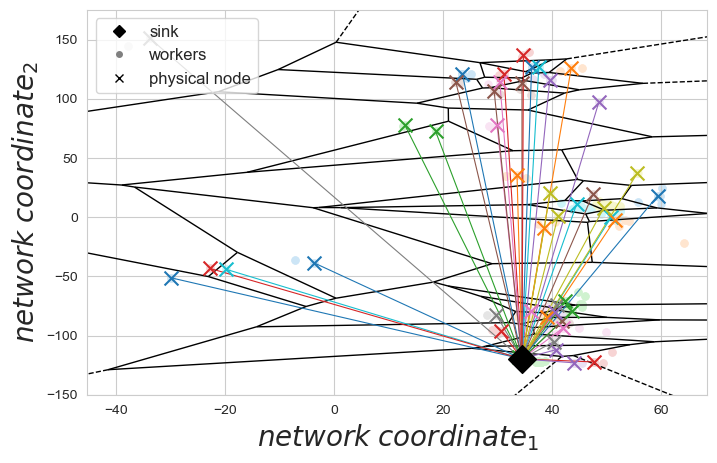

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_cl_join, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/planetlab/planetlab_{0}_clustering.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [29]:
df_stats.head()

,latency_distribution,received_packets
0,0.000000,7978.0
1,46.284809,0.0
2,46.284809,0.0
3,6.771432,0.0
4,24.990054,0.0


### Clustering+Tree - Placement at Intersecting Trees

In [30]:
num_leach_clusters = max(4, int(0.1 * device_number))
df_clTree = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_clTree, ch_indices, centers, u = leachSFClusteringTreeJoin(df, capacity_col, num_leach_clusters, coord_cols)

    # evaluation
    routes = df_clTree["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
    eval_matrix["cl-tree-sf_" + capacity_col] = df_stats.copy()

In [31]:
df_clTree.head()

,oindex,x,y,type,cluster,capacity_5,parent,route,level
0,0,34.4285,-119.7220,SINK,-1,1680,NaN,[],31
1,1,40.7292,-73.9934,SOURCE,9,20,75.0,"[75, 34, 22, 55, 330, 425, 323, 58, 213, 0]",21
2,2,40.7292,-73.9934,SOURCE,9,10,75.0,"[75, 34, 22, 55, 330, 425, 323, 58, 213, 0]",21
3,3,37.4294,-122.1720,SOURCE,35,58,213.0,"[213, 0]",29
4,4,29.7225,-95.3924,SOURCE,44,72,108.0,"[108, 425, 323, 58, 213, 0]",25


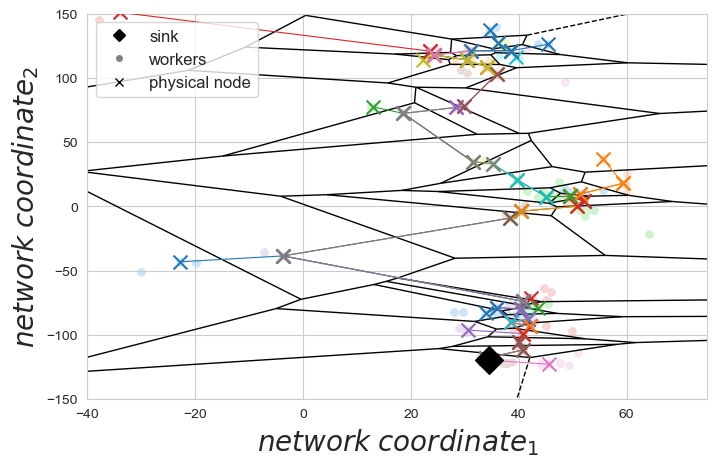

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_clTree, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/planetlab/planetlab_{0}_clustering_tree.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [33]:
df_stats.head()

,latency_distribution,received_packets
0,0.000000,3396.0
1,52.141756,0.0
2,52.141756,0.0
3,6.771432,0.0
4,35.469256,0.0


## Evaluation

In [34]:
homogeneous = ['sink-based', 'source-based', 'tree']
heterogeneous = ["cl-sf", "cl-tree-sf", "top-c"] + ["nova"]

In [35]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

### Latency

In [36]:
approach_order = get_approaches()
eval_colors = get_eval_colors_dict()
markers = get_markers_dict()
styles = get_styles_dict()

sink-based sink-based
source-based source-based
top-c top-c_capacity_inf
tree tree
cl-sf cl-sf_capacity_inf
cl-tree-sf cl-tree-sf_capacity_inf
nova nova_capacity_inf
nova (p) nova_capacity_5


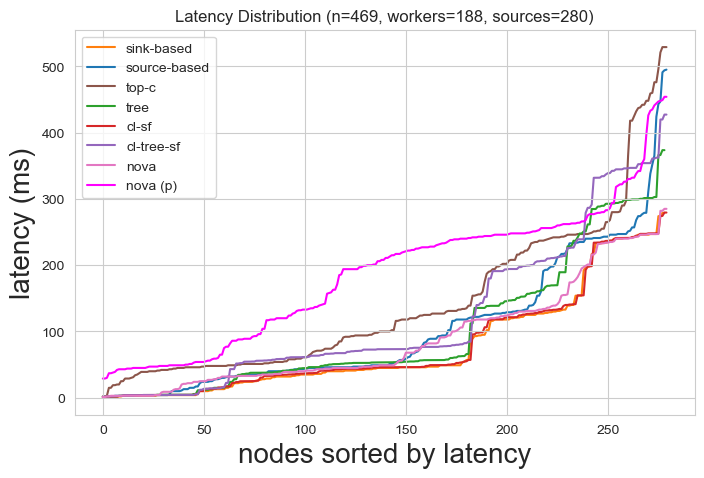

Means:  {'sink-based': np.float64(77.42), 'source-based': np.float64(102.26), 'top-c': np.float64(142.66), 'tree': np.float64(99.17), 'cl-sf': np.float64(79.29), 'cl-tree-sf': np.float64(120.67), 'nova': np.float64(88.91), 'nova (p)': np.float64(185.86)}
Quantiles:  {'sink-based': np.float64(235.0), 'source-based': np.float64(246.0), 'top-c': np.float64(269.2), 'tree': np.float64(292.62), 'cl-sf': np.float64(237.28), 'cl-tree-sf': np.float64(339.23), 'nova': np.float64(235.0), 'nova (p)': np.float64(286.8)}


In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
eval_labels = []
for label in approach_order:
    if label in heterogeneous:
        eval_labels.append((label, label + "_" + eval_columns[0]))
        if label.startswith("nova"):
            eval_labels.append((label + " (p)", label + "_" + eval_columns[-1]))
    else:
        eval_labels.append((label, label))

#plot baselines
for label, eval_col in eval_labels:
    print(label, eval_col)
    eval_df = eval_matrix[eval_col]["latency_distribution"][eval_matrix[eval_col]["latency_distribution"] > 0]
    sv = eval_df.sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[label] = round(eval_df.quantile(0.9), 2)
    mean_dict[label] = round(eval_df.mean(), 2)
    if label == "nova":
        zorder = 100
    else:
        zorder = 0
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=label, color=eval_colors[label], zorder=zorder)

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/planetlab/planetlab_{0}_eval_latency.svg".format(str(device_number)), bbox_inches="tight")

ax1.set_title(f'Latency Distribution (n={device_number}, workers={num_workers}, sources={num_sources})')
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

### Heterogeneity

In [38]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

In [39]:
load_dict = {}
load_norm_dict = {}
nn_dict = {}

for k in approach_order:
    slot_list = []
    slot_list_norm = []
    nn_list = []
    for colname in capacity_columns:
        if k in homogeneous:
            df = eval_matrix_load[k]
        else:
            df = eval_matrix_load[k + "_" + colname]
        df["av_capacity"] = prim_df[colname] - df["received_packets"]
        agg_nodes = df["received_packets"][df["received_packets"] > 0].count()
        tmp_df_sl = df[df["av_capacity"] < 0]
        tmp_df_nn = df[df["av_capacity"] >= 0]
        slot_list.append(tmp_df_sl["av_capacity"].count())
        slot_list_norm.append(int((tmp_df_sl["av_capacity"].count() / agg_nodes) * 100))
        nn_list.append(tmp_df_nn["av_capacity"].count())
    load_dict[k] = slot_list
    load_norm_dict[k] = slot_list_norm
    nn_dict[k] = nn_list

In [40]:
load_dict.keys()

dict_keys(['sink-based', 'source-based', 'top-c', 'tree', 'cl-sf', 'cl-tree-sf', 'nova'])

In [41]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
    print(load_norm_dict[fam])

Fam:  sink-based
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[100, 100, 100, 100, 100, 100]
Fam:  source-based
[np.int64(75), np.int64(69), np.int64(67), np.int64(74), np.int64(75), np.int64(78)]
[53, 48, 47, 52, 53, 55]
Fam:  top-c
[np.int64(12), np.int64(20), np.int64(22), np.int64(17), np.int64(10), np.int64(5)]
[11, 17, 20, 17, 11, 6]
Fam:  tree
[np.int64(160), np.int64(159), np.int64(158), np.int64(159), np.int64(159), np.int64(158)]
[93, 92, 91, 92, 92, 91]
Fam:  cl-sf
[np.int64(30), np.int64(33), np.int64(32), np.int64(35), np.int64(34), np.int64(34)]
[88, 91, 88, 92, 94, 91]
Fam:  cl-tree-sf
[np.int64(45), np.int64(43), np.int64(44), np.int64(43), np.int64(43), np.int64(44)]
[97, 95, 97, 100, 100, 100]
Fam:  nova
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[0, 0, 0, 0, 0, 0]


sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [np.int64(75), np.int64(69), np.int64(67), np.int64(74), np.int64(75), np.int64(78)]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [np.int64(12), np.int64(20), np.int64(22), np.int64(17), np.int64(10), np.int64(5)]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [np.int64(160), np.int64(159), np.int64(158), np.int64(159), np.int64(159), np.int64(158)]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [np.int64(30), np.int64(33), np.int64(32), np.int64(35), np.int64(34), np.int64(34)]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [np.int64(45), np.int64(43), np.int64(44), np.int64(43), np.int64(43), np.int64(44)]
nova (0, (3, 1, 1, 1)) * (0.89019607843137

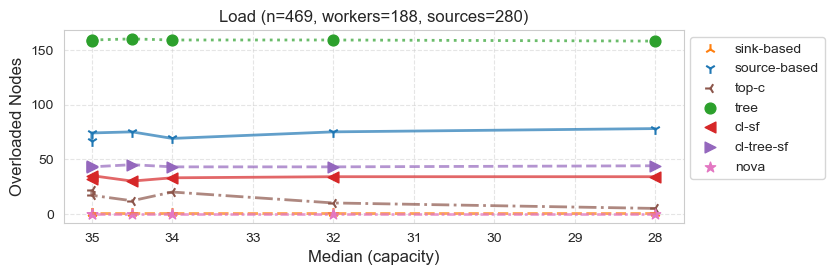

In [42]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 2.5))

medians_plot = medians

for fam in load_dict.keys():
    vals = load_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Nodes", fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/planetlab/planetlab_{device_number}_eval_load_abs_{source_frac}.svg", bbox_inches="tight")
ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [100, 100, 100, 100, 100, 100]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [53, 48, 47, 52, 53, 55]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [11, 17, 20, 17, 11, 6]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [93, 92, 91, 92, 92, 91]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [88, 91, 88, 92, 94, 91]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [97, 95, 97, 100, 100, 100]
nova (0, (3, 1, 1, 1)) * (0.8901960784313725, 0.4666666666666667, 0.7607843137254902) : [0, 0, 0, 0, 0, 0]


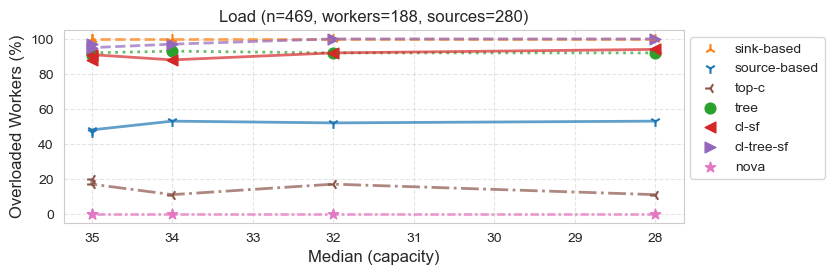

In [48]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 2.5))

medians_plot = medians[1:]

for fam in load_norm_dict.keys():
    vals = load_norm_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Workers (%)", fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/planetlab/planetlab_{device_number}_eval_load_perc_{source_frac}.svg", bbox_inches="tight")

ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

In [46]:
mean_dict

{'sink-based': np.float64(77.42),
 'source-based': np.float64(102.26),
 'top-c': np.float64(142.66),
 'tree': np.float64(99.17),
 'cl-sf': np.float64(79.29),
 'cl-tree-sf': np.float64(120.67),
 'nova': np.float64(88.91),
 'nova (p)': np.float64(185.86)}

In [47]:
quant_dict

{'sink-based': np.float64(235.0),
 'source-based': np.float64(246.0),
 'top-c': np.float64(269.2),
 'tree': np.float64(292.62),
 'cl-sf': np.float64(237.28),
 'cl-tree-sf': np.float64(339.23),
 'nova': np.float64(235.0),
 'nova (p)': np.float64(286.8)}